In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
import matplotlib
matplotlib.rc('font', family='arial')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from skimage.external.tifffile import TiffFile
from skimage.exposure import equalize_adapthist
from fish.util.plot import proj_fuse
from scipy.ndimage.filters import gaussian_filter
from skimage.transform import resize
import flika as flk
from scipy.ndimage import rotate
import dask.array as da
from dask.delayed import delayed
from flika.window import Window as flw
from matplotlib import cm
from skimage.exposure import rescale_intensity as rescale
from functools import partial
from fish.util.plot import depth_project
from skimage.exposure import equalize_adapthist
from fish.util.plot import apply_cmap
from mpl_toolkits.axes_grid1 import make_axes_locatable

from matplotlib.patches import Rectangle

%matplotlib inline
flk.start_flika()

fig_dir = '../../figures/ch2/'

Starting flika
Starting flika inside IPython


In [2]:
def get_mask(data, points):
        from matplotlib.path import Path
        from numpy import meshgrid, zeros, array, where
        mask = zeros(data.shape, dtype='bool')
        
        grid = meshgrid(range(data.shape[0]), range(data.shape[1]))
        coords = list(zip(grid[0].ravel(), grid[1].ravel()))

        path = Path(points)
        in_points = array(coords)[where(path.contains_points(coords))[0]]
        in_points = [tuple(x) for x in in_points]
        for t in in_points:
            mask[t] = True

        return mask

def get_lsm_pixel_spacing(fname):
    from skimage.external.tifffile import TiffFile
    from numpy import array
    data_tif = TiffFile(fname)
    pix_zyx = pix_zyx = np.array([float(t.split(' ')[-1]) for t in data_tif.info().split('\n') if t.find('spacing') > 0])[[1,0,2]]
    return pix_zyx

def slices_to_rect(slices, full_shape, **kwargs):
    from matplotlib.patches import Rectangle
    from numpy import arange
    inds = arange(full_shape[0])[slices[0]], arange(full_shape[1])[slices[1]]
    origin = inds[1][0], inds[0][0]
    width = inds[1][-1] - inds[1][0]
    height = inds[0][-1] - inds[0][0]
    return Rectangle(origin, width, height, **kwargs)


def scale_bar(x0, y0, width, length, um_per_pixel, color='w', offset='auto'):
    from matplotlib.patches import Rectangle    
    from matplotlib.text import Text
    from numpy import array
    
    pix_units = array(um_per_pixel)
    width_um = array([width, length])
    origin_um = array([x0,y0])
    
    scb_dims = width_um / pix_units
    origin = origin_um / pix_units
    
    rect = Rectangle(origin, *scb_dims, fill=True, edgecolor=None, facecolor=color)
    if offset == 'auto':
        offset = (0, -scb_dims[1] * 2)
    else:
        offset = (offset[0] * scb_dims[0], offset[1] * scb_dims[1])
    text = Text(rect.xy[0]+ offset[0], rect.xy[1] + offset[1], f'{width} μm', color=color)
    
    return rect, text

In [3]:
glia_neurons_fname = '/groups/ahrens/ahrenslab/davis/data/confocal/20150401/4dpf_cy214_cy74.lsm'
glia_neurons_data = imread(glia_neurons_fname, plugin='tifffile').squeeze()
glia_neurons_pix_zyx = get_lsm_pixel_spacing(glia_neurons_fname)
aspect = glia_neurons_pix_zyx[0] / glia_neurons_pix_zyx[1]

In [4]:
d_ = glia_neurons_data[:,:,:,1]
#d_ = contrast_adjusted
stretched = resize(d_, output_shape = (d_.shape[0] * np.round(aspect), d_.shape[1], d_.shape[2]))
dog = gaussian_filter(stretched, sigma=(1,1,1)) - gaussian_filter(stretched, sigma=(4,4,4))

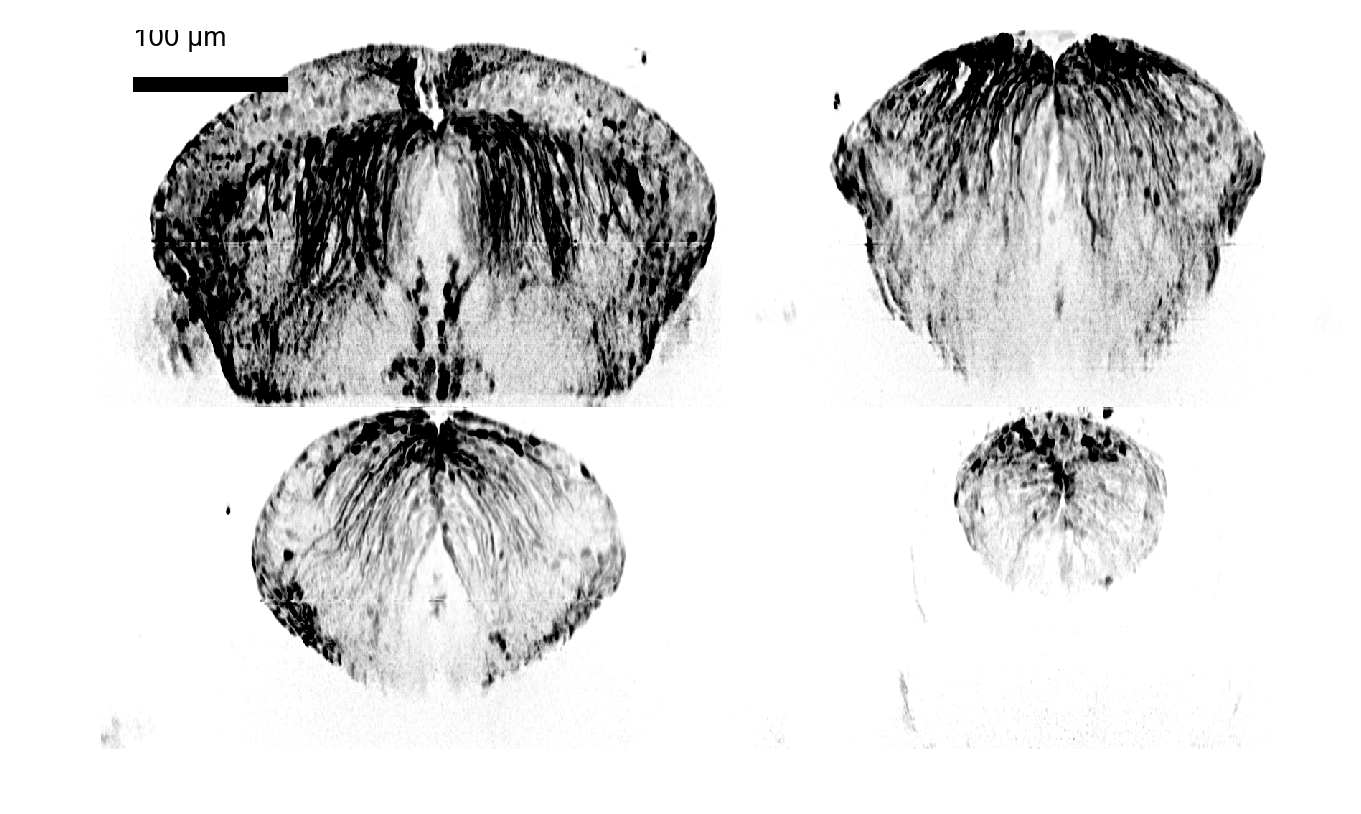

In [5]:
fig, axs = plt.subplots(figsize=(8,8), dpi=200)
from skimage.util import montage
num_ims = 16

crop = (slice(None), slice(None), slice(80,-80))
tmp_ = dog[crop]
mont = np.zeros([num_ims, tmp_.shape[0], tmp_.shape[2]])
step = tmp_.shape[1]//num_ims

inds = [slice(step * ind, step * (ind + 1)) for ind in range(num_ims)]
subsample = np.linspace(4, num_ims-1, 4, dtype='int')
for ind in range(num_ims):
    slab = tmp_[:,inds[ind]].max(1)
    mont[ind] = rescale(slab, in_range=(.0001, slab.max() * .2), out_range=(0,1))

axs.imshow(montage(mont[subsample])[50:-100], cmap='gray_r', clim=(0,1))
scb_len = 100
scb_rect, scb_text = scale_bar(20, 30, scb_len, scb_len//10, (glia_neurons_pix_zyx[1], glia_neurons_pix_zyx[1]), color='k')
axs.add_artist(scb_rect)
axs.add_artist(scb_text)
axs.axis('off')
fig_fname = 'dog_rc_sections.pdf'
plt.savefig(fig_dir + fig_fname)

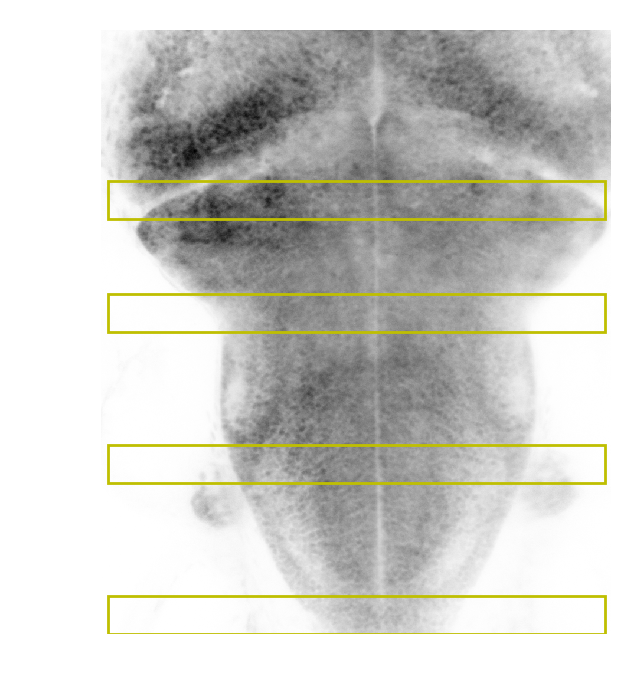

In [6]:
fig, axs = plt.subplots(dpi=200)
fig.set_facecolor('w')
from scipy.ndimage.filters import median_filter
anat = glia_neurons_data[:,:,:,0][crop].mean(0)
axs.axis('off')
axs.imshow(anat, cmap='gray_r')
rects = np.array([Rectangle((10, sl.start), anat.shape[1]-20, sl.stop-sl.start, fill=False, edgecolor='y', linewidth=1) for sl in inds])
[axs.add_patch(r) for r in rects[subsample]]

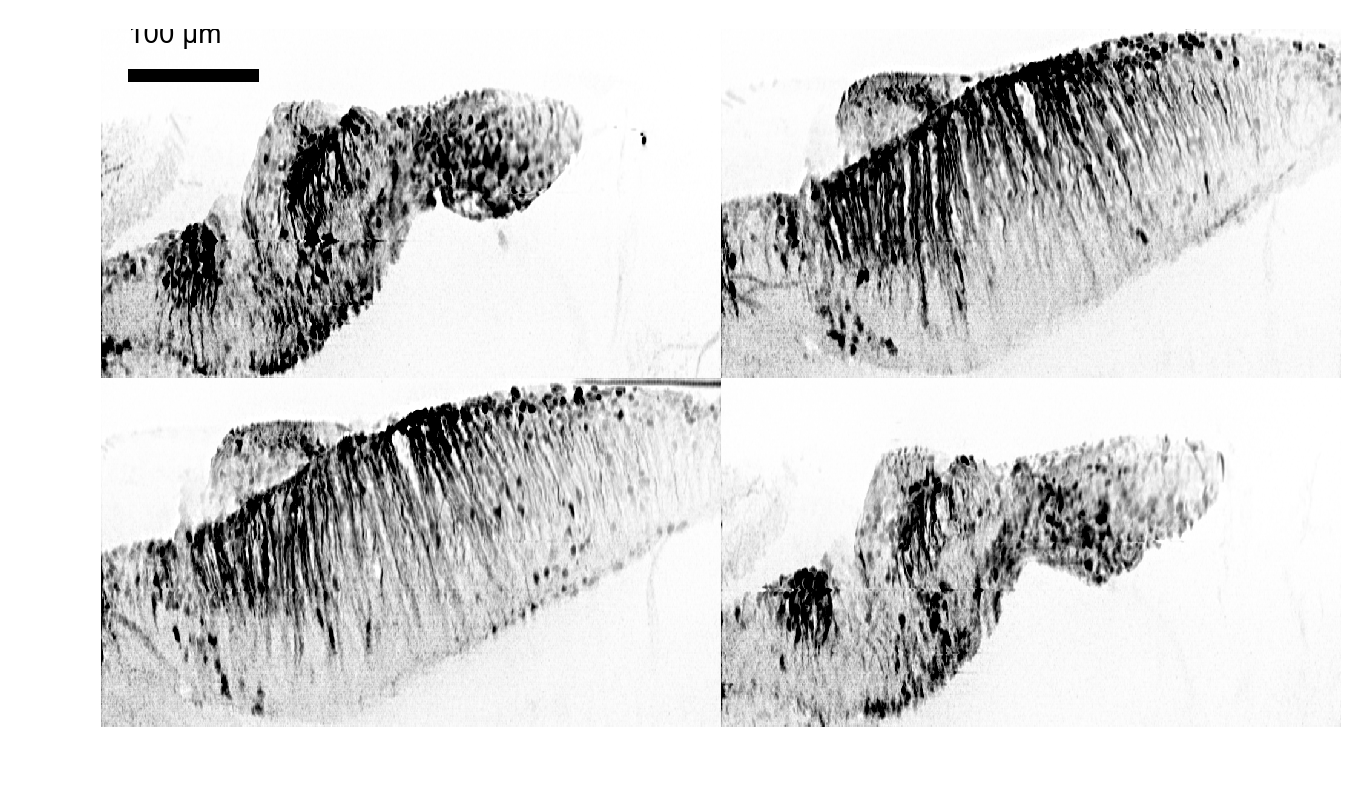

In [7]:
fig, axs = plt.subplots(figsize=(8,8), dpi=200)
from skimage.util import montage
num_ims = 10
crop = (slice(None), slice(None), slice(270,-200))
tmp_2 = dog[crop]
mont = np.zeros([num_ims, tmp_2.shape[0], tmp_2.shape[1]])
step = tmp_2.shape[2]//num_ims
inds = [slice(step * ind, step * (ind + 1)) for ind in range(num_ims)]
subsample = np.linspace(0, mont.shape[0]-1,4, dtype='int')
for ind in range(num_ims):
    mont[ind] = rescale(tmp_2[:,:,inds[ind]].max(2),in_range=(0,.004), out_range=(0,1))


axs.imshow(montage(mont[subsample]), cmap='gray_r', clim=(0,1))
axs.axis('off')

scb_len = 100
scb_rect, scb_text = scale_bar(20, 30, scb_len, scb_len//10, (glia_neurons_pix_zyx[1], glia_neurons_pix_zyx[1]), color='k')
axs.add_artist(scb_rect)
axs.add_artist(scb_text)

fig_fname = 'dog_ml_sections.pdf'
plt.savefig(fig_dir + fig_fname)

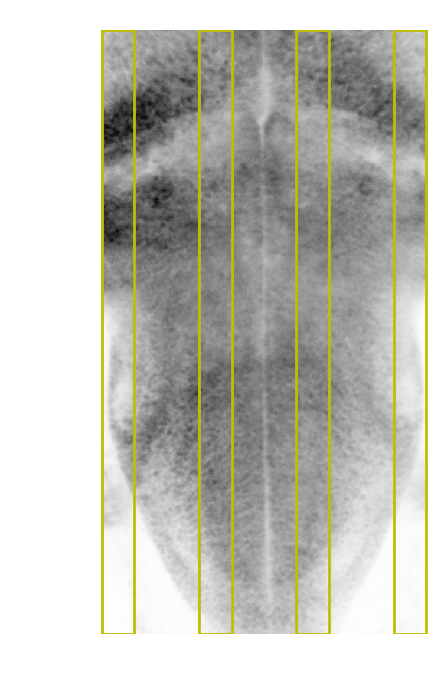

In [8]:
fig, axs = plt.subplots(dpi=200)
fig.set_facecolor('w')
from scipy.ndimage.filters import median_filter
anat = glia_neurons_data[:,:,:,0][crop].mean(0)
axs.axis('off')
axs.imshow(anat, cmap='gray_r')
rects = np.array([Rectangle((sl.start, 0),sl.stop-sl.start, anat.shape[0], fill=False, edgecolor='y', linewidth=1) for sl in inds])
[axs.add_patch(r) for r in rects[subsample]]

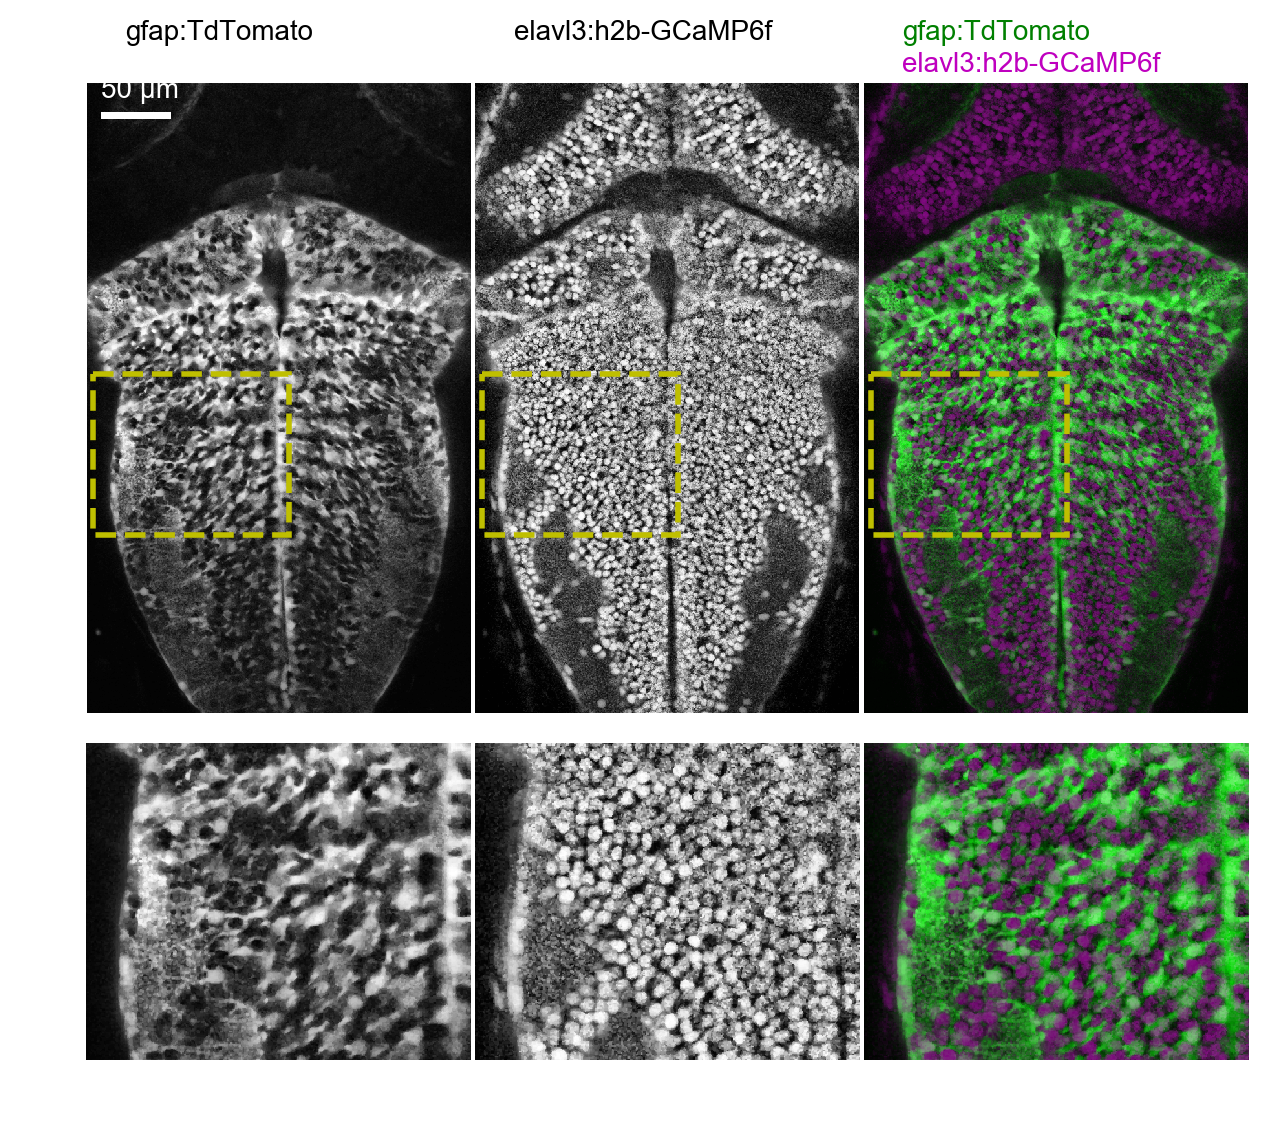

In [9]:
from matplotlib.cm import gray
from skimage.exposure import equalize_hist

z = 40
base_g = glia_neurons_data[z,:,:,1]
base_n = glia_neurons_data[z,:,:,0]
eq = lambda v: equalize_adapthist(v, kernel_size=(base_g.shape[-2] // 40, base_g.shape[-1] // 40), nbins=1024)
filts = [median_filter(eq(d), size=(2,2)) for d in (base_g, base_n)]
crops = (slice(0, 974), slice(250,-180)), (slice(450,700), slice(260,-460))

fig, axs = plt.subplots(figsize=(7.5,7.5),dpi=200, ncols=3, nrows=2, gridspec_kw = {'height_ratios' : (1,1)})
axs_big = axs[0]
axs_zoom = axs[1]
composites = [gray(filts[0][crop]) * np.array([[0,1,0,1]]) + gray(filts[1][crop]) * np.array([.5,0,.5,1]) for crop in crops]

labels = {}
labels['g'] = dict(x = .1, y=1.07, s='gfap:TdTomato', color='k', transform=axs_big[0].transAxes)
labels['n'] = dict(x = .1, y=1.07, s='elavl3:h2b-GCaMP6f', color='k', transform=axs_big[1].transAxes)
labels['merge_g'] = dict(x = .1, y=1.07, s='gfap:TdTomato', color='g', transform=axs_big[2].transAxes)
labels['merge_n'] = dict(x = .1, y=1.02, s='elavl3:h2b-GCaMP6f', color='m', transform=axs_big[2].transAxes)

axs_big[0].imshow(filts[0][crops[0]], cmap='gray', clim=(0,None))
axs_big[1].imshow(filts[1][crops[0]], cmap='gray')
axs_big[2].imshow(composites[0])

for axs_b in axs_big:
    zoom_rect = slices_to_rect(crops[1], base_g.shape, fill=False, edgecolor='y', linestyle='--', linewidth=2)
    zoom_rect.set_xy(zoom_rect.get_xy() - np.array([crops[0][1].start, 0]))
    axs_b.add_patch(zoom_rect)

axs_big[0].text(**labels['g'])
axs_big[1].text(**labels['n'])
axs_big[2].text(**labels['merge_n'])
axs_big[2].text(**labels['merge_g'])

scb_len = 50
scb_rect, scb_text = scale_bar(10, 20, scb_len, scb_len//10, (glia_neurons_pix_zyx[1], glia_neurons_pix_zyx[1]), color='w')
axs_big[0].add_artist(scb_rect)
axs_big[0].add_artist(scb_text)

[ax.axis('off') for ax in axs.ravel()]

axs_zoom[0].imshow(filts[0][crops[1]], cmap='gray', clim=(0, None))
axs_zoom[1].imshow(filts[1][crops[1]], cmap='gray', clim=(0, None))
axs_zoom[2].imshow(composites[1])

plt.subplots_adjust(hspace=-.2, wspace=.01)
fname = f'glial_neuronal_anatomy_z{z}.pdf'
plt.savefig(f'../../figures/ch2/{fname}', transparent=True)

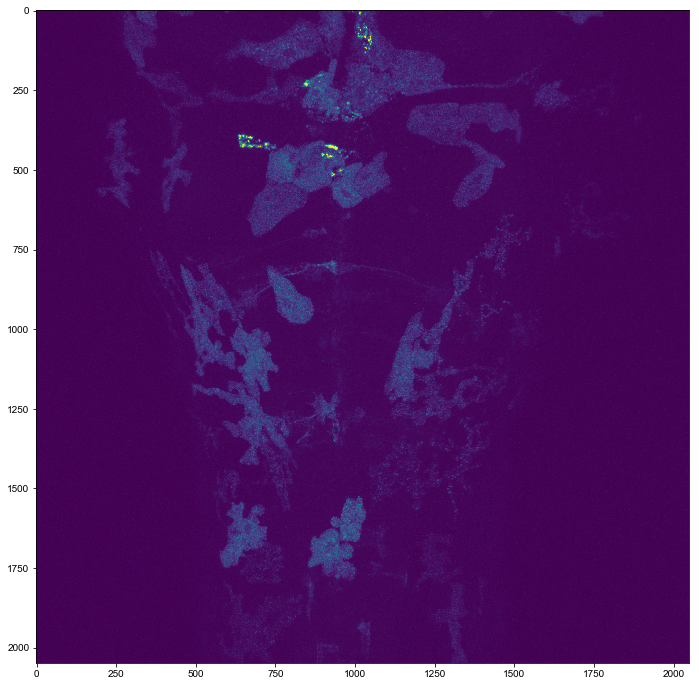

In [294]:
single_cell_fname = '/groups/ahrens/ahrenslab/davis/data/confocal/20150930/8dpf_gfap-brainbow_gfap-gcamp6f_inj_F1.lsm'
single_cell_pixel_spacing = get_lsm_pixel_spacing(single_cell_fname)
single_cells = imread(single_cell_fname, plugin='tifffile').squeeze()[:,:,:,0]
single_cell_pixel_zyx = get_lsm_pixel_spacing(single_cell_fname)
fig, axs = plt.subplots(figsize=(12,12))
plt.imshow(single_cells.max(0))

In [209]:
w = flw(tmp.max(1))

In [228]:
pts = [(int(p.x()), int(p.y())) for p in w.rois[0].getPoints()]
mask= get_mask(tmp.max(1), pts)

In [339]:
masked_data = (tmp.transpose(1,0,2) * mask).transpose(1,0,2)

In [401]:
masked_fname = single_cell_fname.split('/')[-1].split('.')[0] + '_masked_g.tif'
from skimage.io import imsave
imsave(f'/groups/ahrens/ahrenslab/davis/thesis/{masked_fname}', masked_data)

/groups/ahrens/home/bennettd/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /groups/ahrens/ahrenslab/davis/thesis/8dpf_gfap-brainbow_gfap-gcamp6f_inj_F1_masked_g.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


In [289]:
masked_fname = '../../data/ch2/8dpf_gfap-brainbow_gfap-gcamp6f_inj_F1_masked_g.tif'
masked_data = imread(masked_fname)

In [290]:
masked_data.shape

(70, 300, 1150)

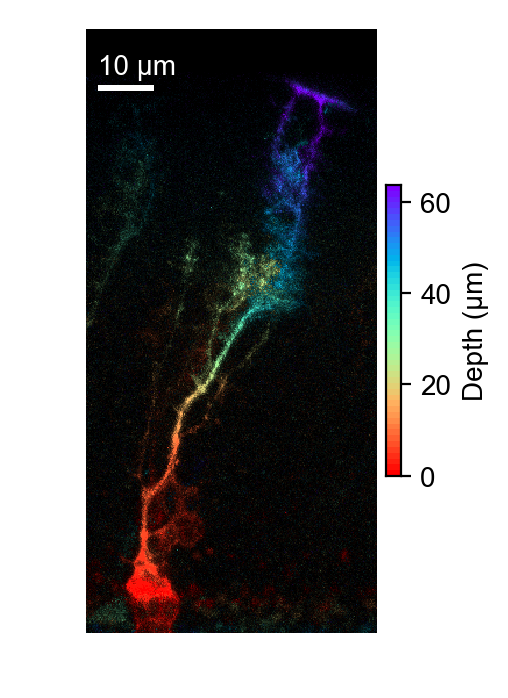

In [320]:
fig, axs = plt.subplots(figsize=(6.5,4),dpi=200)
proj_cmap = 'rainbow_r'
proj_clim = (2, 50)
proj_roi = slice(28, None), slice(0, 250), slice(200,720)
cropped_masked_data = masked_data[proj_roi]

proj_data = depth_project(cropped_masked_data, clim=proj_clim, cmap=proj_cmap, mode='max')
axs.imshow(proj_data.transpose(1,0,2)[:,:,:-1])
divider = make_axes_locatable(axs)
cax = divider.append_axes("right", size="5%", pad=0.05)
dpth = cropped_masked_data.shape[0] * single_cell_pixel_zyx[0]
cax.imshow(np.linspace(1,0).reshape(-1,1), cmap=proj_cmap, extent=(0,dpth/20,0,dpth))
cax.yaxis.tick_right()
cax.yaxis.set_label_position('right')
axs.axis('off')
cax.xaxis.set_visible(False)
cax.set_ylabel('Depth (μm)')

scb_len = 10
scb_rect, scb_text = scale_bar(2, 10, scb_len, scb_len / 10, (single_cell_pixel_zyx[1], single_cell_pixel_zyx[2]))
axs.add_patch(scb_rect)
axs.add_artist(scb_text)

fig_fname = 'single_cell_depth_proj.pdf'
plt.savefig(fig_dir + fig_fname)

In [15]:
glia_nuclei_fname = '/groups/ahrens/ahrenslab/davis/anatomy/6dpf_cy331_f1_dv_1.lsm'
glia_nuclei_zyx = get_lsm_pixel_spacing(glia_nuclei_fname)
aspect = glia_nuclei_zyx[0] / glia_nuclei_zyx[1]
data_r = imread(glia_nuclei_fname, plugin='tifffile').squeeze()

In [11]:
overlap_percent = 10
overlap = (data_r.shape[2] // overlap_percent)
data = np.hstack([np.squeeze(d[:,:,:-overlap]).transpose(0,2,1) for d in data_r]).transpose(0,2,1)

out_range = data.min(), data.max()
def rescaler(v):
    return rescale(v, in_range=tuple(np.percentile(v, [30,99.99])), out_range=out_range)
#rescaler = partial(rescale, out_range=out_range)
data_rescaled = da.from_array(data, chunks=(1, *data.shape[1:])).map_blocks(rescaler, dtype='int').compute()
data_rescaled = rescale(data_rescaled.astype('float'), out_range=(0,1))

ang_xy = -6
data_ro = rotate(data_rescaled, ang_xy, axes=(1,2), cval=0)

In [12]:
def mdp(data, axis, cmap):
    from skimage.exposure import rescale_intensity as rescale
    from numpy import argmax, linspace, zeros
    # max project to get intensity, then use depth to set color
    mx = rescale(data.max(axis).astype('float'), out_range=(0,1))
    remapped = zeros((*mx.shape[1:], 4))
    dp = argmax(data, axis)    
    col_array = cmap(linspace(0, 1, data.shape[axis]))
    remapped = (col_array[dp,:].transpose(2,1,0) * mx.T).transpose(2,1,0)
    
    return remapped
    

In [31]:
flw(data_ro)

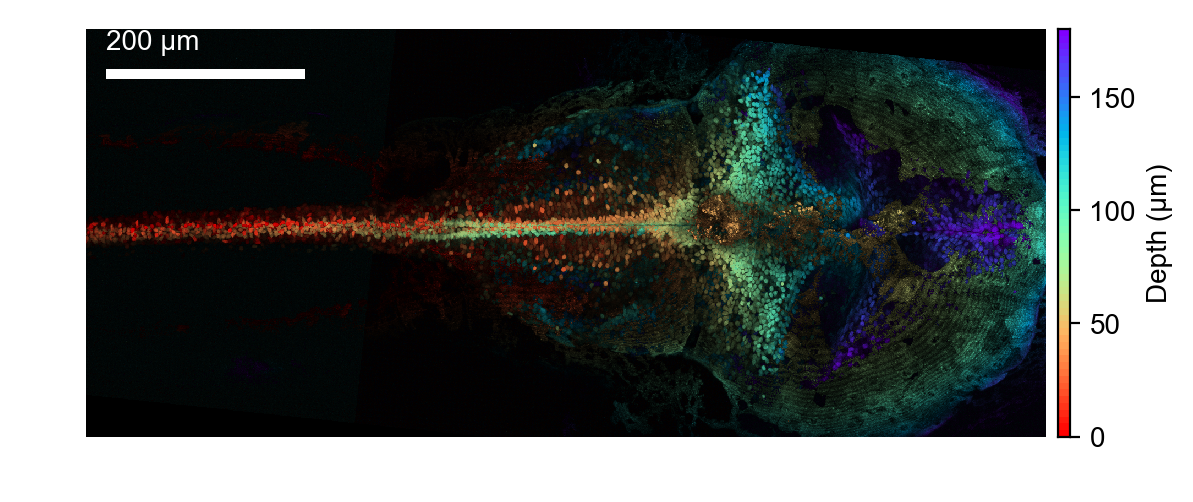

In [28]:
from matplotlib import cm
proj_axis = 0
crop_nuclei = slice(None), slice(120,-120), slice(200,-200)
tmp = mdp(data_ro[crop_nuclei], proj_axis, cm.rainbow_r)[:,:,:-1]
cmap = np.tile(cm.rainbow(np.linspace(0,1,data.shape[proj_axis])), (1,1,1)).transpose(1,0,2)[::-1]
fig = plt.figure(figsize=(6,6), dpi=200)

axs = fig.add_axes([0,0,.8,1]), fig.add_axes([.85,0,.15,1])
axs[0].set_facecolor('k')
axs[0].imshow(tmp)
#axs[0].imshow(tmp[:,:,:-1], aspect=1, interpolation='bicubic')
axs[0].axis('off')
cbar_pos = axs[0].get_position()
pad = .01

cbar_pos.x0 = cbar_pos.x1 + pad
cbar_pos.x1 = cbar_pos.x0 + .01
axs[1].set_position(cbar_pos)
axs[1].imshow(cmap, origin='lower', aspect='auto', extent=(0,1,0,data_ro.shape[proj_axis] * glia_nuclei_zyx[proj_axis]))
axs[1].yaxis.tick_right()
axs[1].tick_params(axis='both', bottom=False, labelbottom=False)
axs[1].yaxis.set_label_position('right')
axs[1].set_ylabel('Depth (μm)')

scb_len = 200
scb_rect, scb_text = scale_bar(20, 40, scb_len, scb_len / 20, (glia_nuclei_zyx[2], glia_nuclei_zyx[1]))
axs[0].add_patch(scb_rect)
axs[0].add_artist(scb_text)
fig_fname = 'mdp_glial_nuclei_dv.pdf'
plt.savefig(fig_dir + fig_fname)

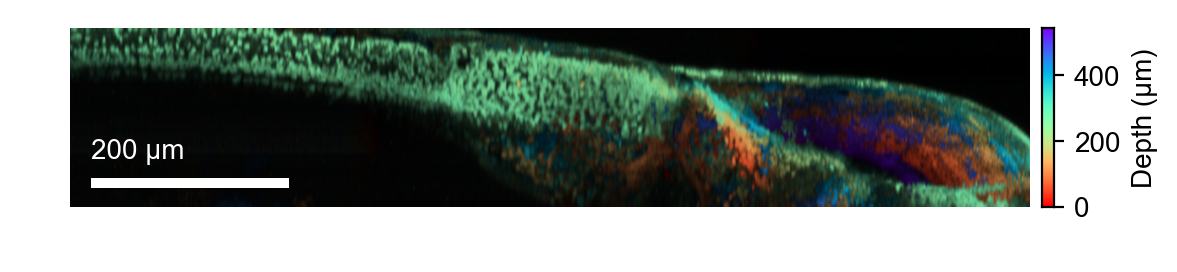

In [29]:
from matplotlib import cm
proj_axis = 1
tmp = mdp(data_ro[crop_nuclei], proj_axis, cm.rainbow_r)
cmap = np.tile(cm.rainbow(np.linspace(0,1,data.shape[proj_axis])), (1,1,1)).transpose(1,0,2)[::-1]
fig = plt.figure(figsize=(6,3), dpi=200)

axs = fig.add_axes([0,0,.8,1]), fig.add_axes([.85,0,.15,1])
axs[0].set_facecolor('k')
axs[0].imshow(tmp[:,:,:-1], aspect=aspect, interpolation='bicubic')
axs[0].axis('off')
cbar_pos = axs[0].get_position()
pad = .01

cbar_pos.x0 = cbar_pos.x1 + pad
cbar_pos.x1 = cbar_pos.x0 + .01
axs[1].set_position(cbar_pos)
axs[1].imshow(cmap, origin='lower', aspect='auto', extent=(0,1,0, data_ro.shape[proj_axis] * glia_nuclei_zyx[proj_axis]))
axs[1].yaxis.tick_right()
axs[1].tick_params(axis='both', bottom=False, labelbottom=False)
axs[1].yaxis.set_label_position('right')
axs[1].set_ylabel('Depth (μm)')

scb_len = 200
scb_rect, scb_text = scale_bar(20, 150, scb_len, scb_len / 20, (glia_nuclei_zyx[1], glia_nuclei_zyx[0]))
axs[0].add_patch(scb_rect)
axs[0].add_artist(scb_text)
fig_fname = 'mdp_glial_nuclei_ml.pdf'
plt.savefig(fig_dir + fig_fname)

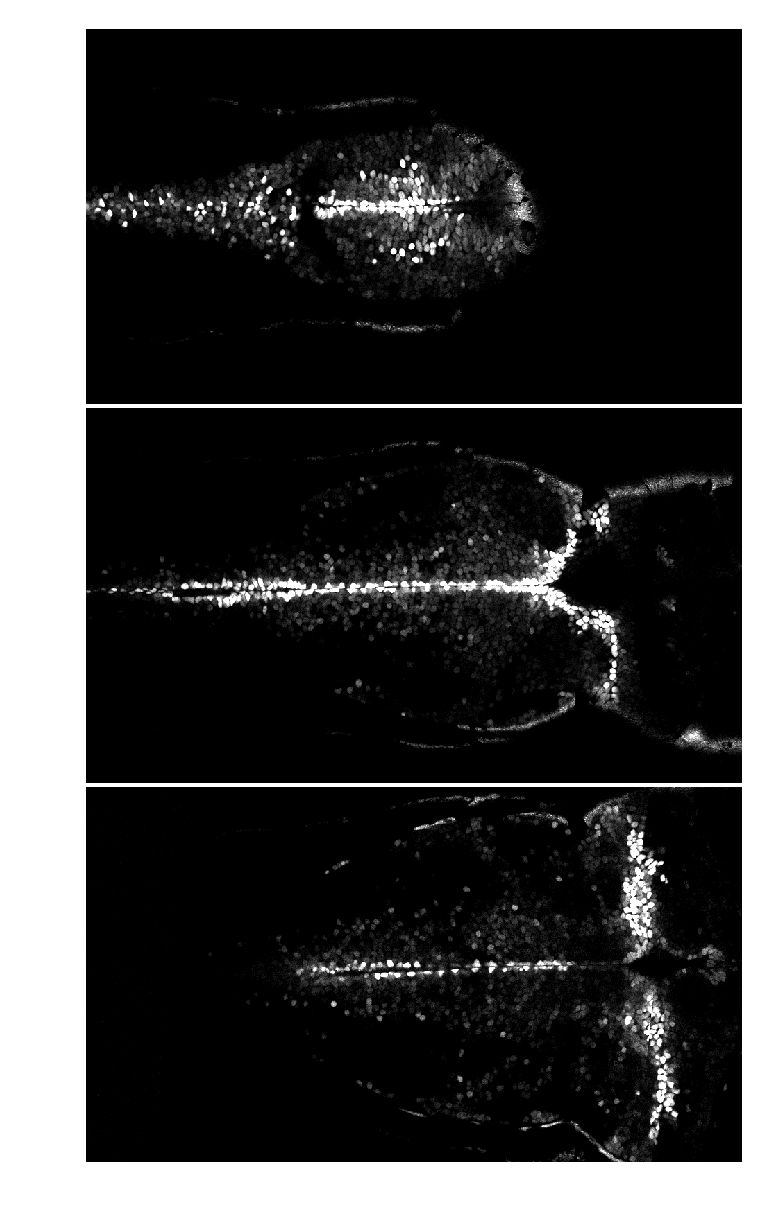

In [56]:
fig, axs = plt.subplots(nrows=3, dpi=200, figsize=(7.5,7.5))
[ax.axis('off') for ax in axs]
cmap = 'gray'
clim=(.025,.4)
crop_nuclei_zoom = slice(None), slice(220,-220), slice(600,-600)
planes = (10,20,30)
for ind, pl in enumerate(planes):
    axs[ind].imshow(data_ro[crop_nuclei_zoom][pl], clim=clim, cmap=cmap)
plt.subplots_adjust(wspace=0, hspace=.01)

In [258]:
# store the coordinates of some example cells
thr = .2
supra = (data_rescaled[crop] > thr).sum()
cell_vol = 49

print(supra / cell_vol * .9)
print(supra / cell_vol)
print(supra / cell_vol * 1.1)

11828.589795918368
13142.877551020409
14457.165306122452


In [17]:
flw(data)

/groups/ahrens/home/bennettd/anaconda3/lib/python3.6/site-packages/pyqtgraph/imageview/ImageView.py:588: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data = data[sl]


In [99]:
import czifile

In [100]:
ls /groups/ahrens/ahrenslab/davis/data/confocal/*

/groups/ahrens/ahrenslab/davis/data/confocal/5dpf_cy214xcy74_f1_DV.czi*
/groups/ahrens/ahrenslab/davis/data/confocal/Her4.1-TetA-GBD-2a-mCherry x tre-itTA-2a-EGFP-cmlc2-egfp 4 day 36 hr inc f2 stiched_C1.tif*
/groups/ahrens/ahrenslab/davis/data/confocal/Netsg2(dbh).tdTomato-bfillAF488-5dpf-f2-dorsal-20160111.lsm*
/groups/ahrens/ahrenslab/davis/data/confocal/Thumbs.db*

/groups/ahrens/ahrenslab/davis/data/confocal/20140824:
20140824_F1/

/groups/ahrens/ahrenslab/davis/data/confocal/20140831:
GFAP(RFP_GCaMP)_HuC_GCaMP_11dpf_fore_F1_0-182.tif*
GFAP(RFP_GCaMP)_HuC_GCaMP_11dpf_fore_F1_0-182.xml*
GFAP(RFP_GCaMP)_HuC_GCaMP_11dpf_fore_F1.lsm*
GFAP(RFP_GCaMP)_HuC_GCaMP_11dpf_fore_F1.xml*
GFAP(RFP_GCaMP)_HuC_GCaMP_11dpf_fore_F2.lsm*
GFAP(RFP_GCaMP)_HuC_GCaMP_11dpf_fore_F2.xml*
GFAP(RFP_GCaMP)_HuC_GCaMP_11dpf_posthind_F2.lsm*
GFAP(RFP_GCaMP)_HuC_GCaMP_11dpf_posthind_F2.xml*
GFAP(RFP_GCaMP)_HuC_GCaMP_11dpf_spinal_F2.lsm*
Thumbs.db*
tif/

/groups/ahrens/ahrenslab/davis/data/confocal/20140907:
GFAP(

In [284]:
gfap = imread('/groups/ahrens/ahrenslab/davis/data/confocal/20180125/6dpf_cy214xcy74_f1_DV.lsm', plugin='tifffile').squeeze()
#gfap = rescale(gfap[:,:,:,0].transpose(0,2,1).astype('float32'), out_range=(0,1))

In [285]:
gfap.shape

(271, 2, 2000, 2000)

In [164]:
her4 = imread('/groups/ahrens/ahrenslab/davis/data/confocal/Her4.1-TetA-GBD-2a-mCherry x tre-itTA-2a-EGFP-cmlc2-egfp 4 day 36 hr inc f2 stiched_C1.tif', plugin='tifffile').squeeze()
her4 = rescale(her4.astype('float32'), out_range=(0,1))

In [276]:
flw(her4)

/groups/ahrens/home/bennettd/miniconda/lib/python3.6/site-packages/pyqtgraph/imageview/ImageView.py:588: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data = data[sl]


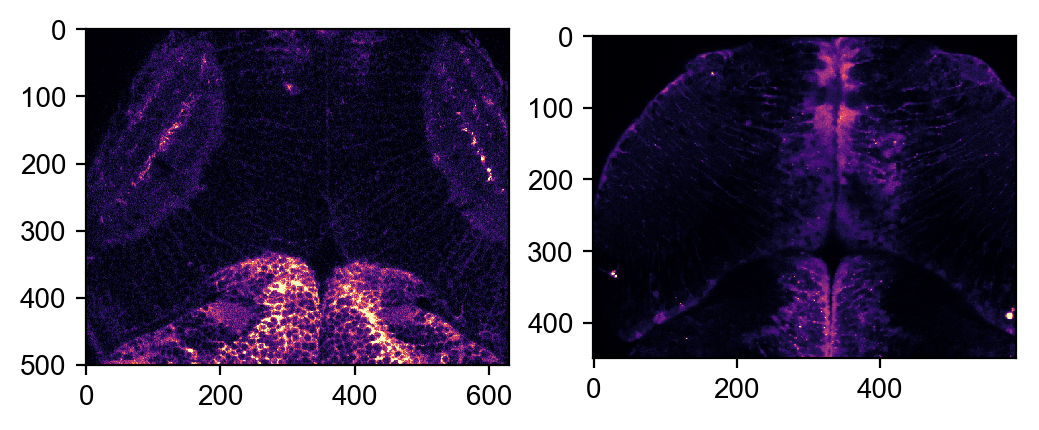

In [281]:
fig, axs = plt.subplots(dpi=200, ncols=2)
her4_roi = 40, slice(450, 900), slice(140, 730)
gfap_roi = 40, slice(500), slice(50,680)
axs[1].imshow(her4[her4_roi], cmap='magma', clim=(0,.5))
axs[0].imshow(gfap[gfap_roi], cmap='magma', clim=(0,.5))

In [112]:
flw(tmp[:,:,:])

/groups/ahrens/home/bennettd/miniconda/lib/python3.6/site-packages/pyqtgraph/imageview/ImageView.py:588: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data = data[sl]


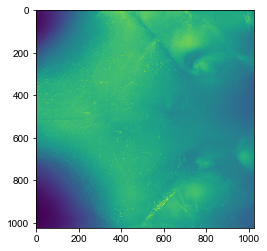

In [108]:
plt.imshow(tmp.max(0)[:,:,])

In [146]:
d_ = tmp
#d_ = contrast_adjusted
stretched = resize(d_, output_shape = (d_.shape[0] * np.round(aspect), d_.shape[1], d_.shape[2]))
dog = gaussian_filter(stretched, sigma=(1,1,1)) - gaussian_filter(stretched, sigma=(4,4,4))

In [147]:
flw(dog)

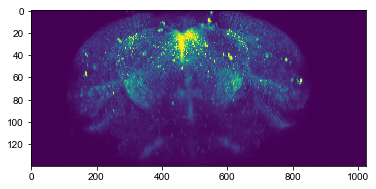

In [144]:
plt.imshow(tmp.max(1), aspect=3.4)